## Product Recommendation System

In this notebook, we will attempt to built a product recommendation system to encourage upselling and crossselling. These objectives will be achieved through two separate methods:
1. Upselling: Develop a content-based recommendation system that searches for products with similar descriptions. Given a product, it will output similar products that are of a higher price. These will be primarily be recommended to buyers only during the visit session where they show interest in a product, from the point they click on it to the point they checkout.
<br>
<br>
2. Crossselling: Identify products that are frequently bought together and recommend them to buyers. This can be recommended to buyers after they have placed an item in their basket, even in marketing emails sent to buyers after their purchase. 

As covered in GoogleAnalyticsAnalysis.ipynb, most visitors to the store are first time buyers. This section will attempt to expand upon this finding by delving deeper into the types of products that repeat customers frequently buy, as well as products that are often bought together. In doing so, we aim to better understand the buying patterns of customers, which will allow us to create an appropriate marketing strategy. 

In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

nltk.download('wordnet')
nltk.download('punkt_tab')


warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option('display.width', 10000)

# Change the project name here to your project name in your account
client = bigquery.Client(project="ambient-sylph-426620-g6") # Odele

[nltk_data] Downloading package wordnet to /Users/admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/admin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Product similarity score

To construct a function capable of producing the similarity score between two products, we need to first query data on all products available on the store.

In [321]:
query = '''
    SELECT distinct
        product.productSKU AS product_id
        ,product.productBrand AS product_brand
        ,product.productVariant AS product_variant
        ,product.v2ProductName AS product_name
        ,product.v2ProductCategory AS product_category
        ,product.productPrice/1000000 AS price_temp
        ,count(DISTINCT date_trunc(PARSE_DATETIME("%Y%m%d %H:%M:%S", CONCAT(date, ' ' ,hour,':',minute,':00')), day)) as days
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
        UNNEST(hits) AS hits
    LEFT JOIN UNNEST(hits.product) AS product ON TRUE
    GROUP BY 1,2,3,4,5,6
    
'''

rows = client.query(query)
raw_product_data = rows.to_dataframe()


We proceed to clean the dataset to prepare it for further analysis. A product's description will be taken to be the combination of name, brand, variant* and category.
<br>
<br>
*Variant refers to attributes of the product, such as size and colour

In [322]:
# Remove rows with invalid product IDs
raw_product_data.dropna(subset = ['product_id'], inplace = True)

# Removing special characters and leading whitespace 
raw_product_data['product_variant'] = raw_product_data['product_variant'].str.lstrip()
replacements = {'2XL': 'XXL', '3XL':'XXXL', 'L/XL': 'LG XL', 'S/M': 'SM MD', 'M/L': 'MD LG'}
raw_product_data['product_variant'].replace(replacements, inplace = True)

raw_product_data['product_category'] = raw_product_data['product_category'].str.replace(r"[\'&]",'',regex = True)
raw_product_data['product_category'] = raw_product_data['product_category'].str.replace(r"[-/]", " ", regex = True)
raw_product_data['product_category'] = raw_product_data['product_category'].str.replace(r"\$\{.*?\}", '', regex = True)

raw_product_data['product_name'] = raw_product_data['product_name'].str.replace('/', ' ')
raw_product_data['product_name'] = raw_product_data['product_name'].str.replace(r"[\'-]",'',regex = True)

# Turn fields with placeholder names into NA
raw_product_data.replace(['(not set)', 'Single Option Only'], np.nan, inplace = True)

# NA fields will not contribute anything to the product description
raw_product_data['product_brand'].fillna('', inplace = True)
raw_product_data['product_variant'].fillna('', inplace = True)
raw_product_data['product_category'].fillna('', inplace = True)
raw_product_data['product_name'].fillna('', inplace = True)

# Join product category, brand, name and variant into single string
raw_product_data['product_desc'] = raw_product_data.apply(lambda x: ' '.join([x['product_category'], x['product_brand'], x['product_name'], x['product_variant']]), axis = 1)

# Resolve price discrepancies by replacing by modal price
product_by_id = raw_product_data.groupby(['product_id', 'price_temp'])['days'].sum().reset_index()
product_prices = product_by_id.loc[product_by_id.groupby('product_id')['days'].idxmax(), ["product_id", "price_temp"]]
product_prices.rename({"price_temp":"product_price"}, axis = 1, inplace = True)
raw_product_data = raw_product_data.merge(product_prices, how = 'left', on = 'product_id')
raw_product_data.drop(['days', 'price_temp'], axis = 1, inplace = True)

# Resolve discrepancies in product descriptions by combining descriptions
product_df = raw_product_data.groupby(['product_id', 'product_price'])['product_desc'].apply(lambda x: ' '.join(set(x))).reset_index()

# Create product id to name dictionary for future reference
id_name_dict = dict(zip(raw_product_data['product_id'], raw_product_data['product_name']))

In [323]:
# Tokenize and lemmatize product descriptions
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
product_df['tokens'] = product_df['product_desc'].apply(lambda x: word_tokenize(x))

def lemmatize(l):
    lemmatized = [word.lower() for word in l if word not in stop_words and word.isalpha()]
    return [lemmatizer.lemmatize(word) for word in lemmatized]

product_df['lemma'] = product_df['tokens'].apply(lambda x: lemmatize(x))

To calculate the similarity score of product pairs, we will create embeddings (i.e. vector representations) for each product and calculate cosine similarity as a measure of similarity. The formula for cosine similarity is:
$$
\text{cosine similarity} = \frac{\mathbf{A} \cdot \mathbf{B}}{||\mathbf{A}|| \cdot ||\mathbf{B}||}
$$

where A and B represent the embeddings for product A and B respectively. 

Cosine similarity is measured on a scale of 0 to 1, with higher values representing higher similarity.

In [324]:
# Download and load GloVe embeddings
model = api.load('glove-wiki-gigaword-100')

In [325]:
# Get vector embedding associated with each product 
def mean_vector(desc, model, vocab, id_map, vector_dim):
    vec = np.zeros(vector_dim)
    word_count = 0

    for word in desc:
        if word in id_map:                      # verify that there is a vector embedding for that word
            vec = np.add(vec, model[word])     
            word_count += 1
    vec = np.divide(vec, word_count)            # find mean of vectors representing words in product description
    return np.array(vec)

vocab = set(product_df['lemma'].sum())
id_map = model.key_to_index
corpus = product_df['lemma']
product_df['vector'] = product_df.apply(lambda x: mean_vector(x['lemma'], model, vocab, id_map, 100), axis = 1)

def similarity(id1, id2):                       # function that will take in 2 product IDs and output similarity score
    vec1 = np.array([product_df.loc[product_df['product_id'] == id1, 'vector'].values[0]]) 
    vec2 = np.array([product_df.loc[product_df['product_id'] == id2, 'vector'].values[0]]) 
    return cosine_similarity(vec1, vec2)[0][0]

## Exploratory data analysis

We first examine the shopping behaviours of visiters by looking at the composition of each basket purchased. In this case, we will define a  basket as all the items bought by a single visitor during a single visit. This allows us to factor for visitors who may make multiple transactions in the same visit as they forgot to purchase certain items.

In [326]:
query = '''
    SELECT DISTINCT
        fullVisitorId as user_id
        ,visitId as visit_id
        -- ,PARSE_DATETIME("%Y%m%d %H:%M:%S", CONCAT(date, ' ' ,hour,':',minute,':00')) AS purchase_date
        ,product.productSKU AS product_id
        -- ,product.v2ProductName AS product_name
        -- ,product.v2ProductCategory AS product_category
        ,product.productPrice/1000000 AS product_price
        -- ,product.productQuantity AS product_qty
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
        UNNEST(hits) AS hits
    LEFT JOIN UNNEST(hits.product) AS product ON TRUE
    WHERE true
        and hits.eCommerceAction.action_type  = '6'
        and product.productQuantity > 0
'''

rows = client.query(query)
all_purchases = rows.to_dataframe()

all_purchases['basket_id'] = all_purchases.groupby(['user_id', 'visit_id']).ngroup()
basket_df = all_purchases['basket_id'].value_counts().reset_index(name = 'unique_items_in_basket')
all_purchases = all_purchases.merge(basket_df, on = 'basket_id', how = 'left')

85% of visiters buy up to 5 unique products, though a majority buy only 1 or 2.

   unique_items_in_basket    cumsum
0                       1  0.367186
1                       2  0.579134
2                       3  0.710736
3                       4  0.801299
4                       5  0.858268


Text(0.5, 1.0, 'Cumulative line plot of number of unique items per checkout')

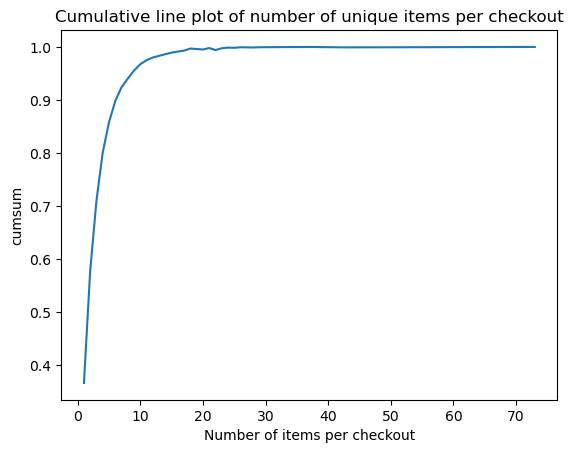

In [327]:
basket_item_cnt_df = basket_df['unique_items_in_basket'].value_counts().reset_index()
basket_item_cnt_df['prop'] = basket_item_cnt_df['count']/basket_item_cnt_df['count'].sum()
basket_item_cnt_df['cumsum'] = basket_item_cnt_df['prop'].cumsum()

print(basket_item_cnt_df[['unique_items_in_basket', 'cumsum']].head())

sns.lineplot(data = basket_item_cnt_df, x = 'unique_items_in_basket', y = 'cumsum')
plt.xlabel('Number of items per checkout')
plt.title('Cumulative line plot of number of unique items per checkout')

Among those that buy 2 or more unique products, the price range tends to be quite small. 

Text(0.5, 1.0, 'Histogram of price ranges')

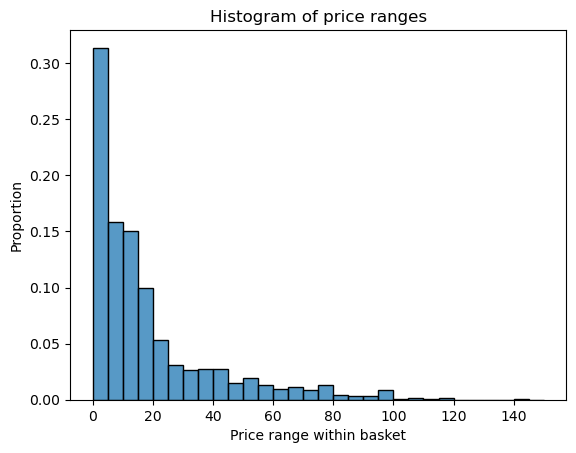

In [328]:
max_price = all_purchases.loc[all_purchases['unique_items_in_basket'] > 1].groupby('basket_id')['product_price'].max().reset_index()
min_price = all_purchases.loc[all_purchases['unique_items_in_basket'] > 1].groupby('basket_id')['product_price'].min().reset_index()
basket_price_range = max_price.merge(min_price, on = 'basket_id', how = 'left', suffixes = ['_max', '_min'])
basket_price_range['range'] = basket_price_range['product_price_max'] - basket_price_range['product_price_min']
sns.histplot(basket_price_range['range'], stat = 'proportion', binwidth = 5)
plt.xlabel('Price range within basket')
plt.title('Histogram of price ranges')

The mean similarity scores between all product pairs in a basket follows a slightly right-skewed bell-shaped distribution. The average score is 0.73 with a median of 0.72, indicating that products within a basket tend to be rather similar.

In [ ]:
def mean_similarity(basket_id):
    sum_score = 0
    pair_cnt = 0
    df = all_purchases.loc[all_purchases['basket_id'] == basket_id]
    print(len(df))
    for i in range(len(df)):
        product1 = df.iloc[i]['product_id']
        for j in range(i + 1, len(df)):
            product2 = df.iloc[j]['product_id']
            sim = similarity(product1, product2)
            sum_score += sim
            pair_cnt += 1
    return sum_score/pair_cnt

basket_ids = all_purchases.loc[all_purchases['unique_items_in_basket'] > 1]['basket_id'].unique().tolist()
mean_similarity_scores = [mean_similarity(x) for x in basket_ids]

basket_similarity = pd.DataFrame(list(zip(basket_ids, mean_similarity_scores)), columns = ['basket_id', 'mean_similarity_score'])

Mean: 0.7273395994812951, median: 0.711706408067435


Text(0.5, 1.0, 'Histogram of mean similarity scores')

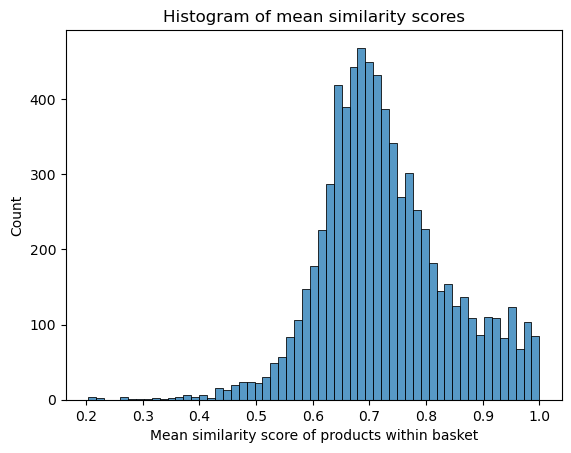

In [330]:
print(f"Mean: {basket_similarity['mean_similarity_score'].mean()}, median: {basket_similarity['mean_similarity_score'].median()}")

sns.histplot(basket_similarity['mean_similarity_score'])
plt.xlabel('Mean similarity score of products within basket')
plt.title('Histogram of mean similarity scores')

Zooming in on repeat customers, we can also examine the types of products that users like to buy on their second visit - do they tend to return for similar products, or are they trying something new?

In [335]:
query = '''
    WITH buyers as (
    SELECT DISTINCT
        fullVisitorId as user_id
        ,visitId as visit_id
        ,DATE_TRUNC(PARSE_DATETIME("%Y%m%d %H:%M:%S", CONCAT(date, ' ' ,hour,':',minute,':00')), day) AS purchase_date
        ,product.productSKU AS product_id
        ,product.productPrice/1000000 AS product_price
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
        UNNEST(hits) AS hits
    LEFT JOIN UNNEST(hits.product) AS product ON TRUE
    WHERE true
        and hits.eCommerceAction.action_type  = '6'
        and product.productQuantity > 0
)

    ,order_purchases AS(
        SELECT user_id
            ,purchase_date
            ,visit_id
            ,ROW_NUMBER() OVER (
                PARTITION BY user_id
                ORDER BY min(purchase_date)) purchase_cnt
    FROM buyers
    GROUP BY 1,2,3
    ORDER BY 1, 2, 3
    )

    ,second_purchase AS(
        SELECT distinct
            user_id
            ,visit_id
            ,purchase_date
            ,product_id
            ,product_price
        FROM order_purchases
        LEFT JOIN buyers USING (user_id, visit_id, purchase_date)
        WHERE purchase_cnt = 2
        ORDER BY 1,2
    )

    SELECT 
        user_id 
        ,buyers.visit_id as first_purchase_visit_id
        ,buyers.purchase_date as first_purchase_date
        ,buyers.product_id as first_purchase_product_id
        ,buyers.product_price as first_purchase_price
        ,sp.visit_id as second_purchase_visit_id
        ,sp.purchase_date as second_purchase_date
        ,sp.product_id as second_purchase_product_id
        ,sp.product_price as second_purchase_price
    FROM order_purchases op
    LEFT JOIN buyers using (user_id, visit_id, purchase_date)
    LEFT JOIN second_purchase sp USING (user_id)
    WHERE op.purchase_cnt = 1
        AND sp.visit_id is not null
    ORDER BY 1,2, 3    
'''

rows = client.query(query)
first_two_purchases = rows.to_dataframe()

The similarity scores between the first and second basket follow a similar distribution to the basket similarity scores. It seems that users tend to remain equally adventurous when they return the second time.

Mean: 0.7180514543469988, median: 0.7023848445197698


Text(0.5, 1.0, 'Histogram of mean similarity scores between first two baskets')

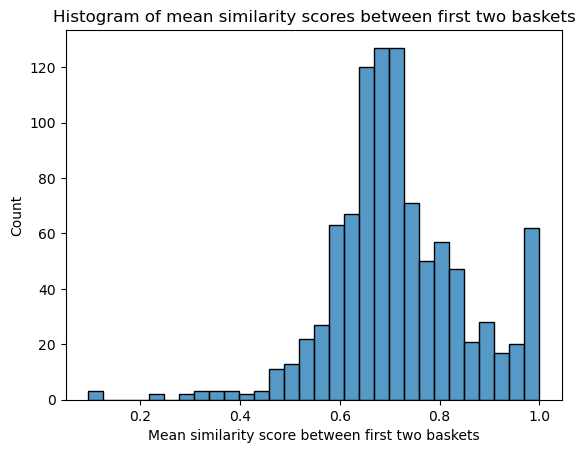

In [336]:
first_two_purchases['similarity'] = first_two_purchases.apply(lambda x: similarity(x['first_purchase_product_id'], x['second_purchase_product_id']), axis = 1)
first_two_purchases_similarity = first_two_purchases.groupby('user_id')['similarity'].mean().reset_index()
print(f'Mean: {first_two_purchases_similarity['similarity'].mean()}, median: {first_two_purchases_similarity['similarity'].median()}')
sns.histplot(first_two_purchases_similarity['similarity'])
plt.xlabel('Mean similarity score between first two baskets')
plt.title('Histogram of mean similarity scores between first two baskets')

Based on our analysis of product quantity, price range and product similarity within baskets, we can conclude that visitors like to buy a **small number of products per visit** and **do not shop very diversely**.

This suggests that to increase customer retention and drive product sales, we should try to **promote products that are closely related to each other**.

## Upselling

Upselling can be integrated into the e-commerce website by showing ads for products that are similar to the ones that the user has expressed interest in. This can be in the form of a click, view, impression or add-to-cart action. Since we have discovered that users like to buy similar items during repeat purchases, these can also be advertised to them during future visits.
<br>
<br>
We can find the most similar products for a given product by filtering based on cosine similarity score and only selecting products that are more expensive.

In [337]:
def upsell(id, lim = -1):                                    # this function will output the top x most similar products to a given product, where x is defined by the user.
    mat = np.vstack(product_df['vector'])                                                       # embeddings for each product
    base_vec = np.array([product_df.loc[product_df['product_id'] == id, 'vector'].values[0]])   # embedding for queried product
    cos_sim = cosine_similarity(base_vec, mat).flatten()                                        # find cosine similarity between queried product and all other products

    df = product_df.copy()
    df['similarity'] = cos_sim
    df.drop(['tokens', 'lemma', 'vector'], axis = 1, inplace = True)
    curr_price = df.loc[df['product_id'] == id, 'product_price'].values[0]                      # obtain price of current product
    df = df.loc[df['product_id'] != id]

    # print(f'Current item is sold for {curr_price}')
    if lim != -1:
        return df.sort_values('similarity', ascending = False).loc[(df['product_id'] != id) & (df['product_price'] > curr_price) & (df['similarity'] > 0.8), 'product_id'].values[:lim]  # only return products that are more expensive
    else:
        return df.sort_values('similarity', ascending = False).loc[(df['product_id'] != id) & (df['product_price'] > curr_price) & (df['similarity'] > 0.8), 'product_id'].values

#Example
upsell('GGOEGADJ059417', 10)


array(['GGOEGADJ059416', 'GGOEGADJ059415', 'GGOEGADJ059414',
       'GGOEGADJ059413', 'GGOEGAAX0594', 'GGOEGADC059516', 'GGOEGAAX0595',
       'GGOEGADJ057117', 'GGOEGADJ057116', 'GGOEGADJ057118'], dtype=object)

## Crossselling

Similar to upselling, crossselling can be integrated into the website through display ads. However, it should only be implemented once a user has placed an item in their basket, as the association rules developed are prefaced on the first item being purchased. Recommendations for complementary products can be used to reactivate churned customers by sending users advertising emails the list of complementary after they have completed the purchase (e.g. 'Other items you might like'), or when there are discounts on complementary products.

To determine which products are complementary with each other, we can perform Market Basket Analysis (MBA) on the baskets of buyers who purchase more than 1 item at a time. We will be using the Apriori algorithm to generate association rules; this involves calculating 3 metrics:
- Support: How often an item/itemset is bought
- Confidence (of A to B): How likely item B is bought when item A is bought
- Lift (of A to B): Confidence of A to B, while adjusting for popularity of B alone

Following Dogan (2023), we will only be considering pairs with minimum support 0.0005 and minimum confidence 0.35. We adjusted the confidence threshold from Dogan's 0.45 to broaden the number of associated pairs, which were otherwise quite low. This is in line with Aguinis et al. (2013), who recommends tailoring the thresholds based on the problem.

In [338]:
# Calculate confidence and lift of all product pairs

basket_product_matrix = pd.pivot_table(all_purchases, index='basket_id', columns='product_id', aggfunc='size', fill_value=0)
basket_product_matrix - (basket_product_matrix > 0).astype(int)
total_baskets = all_purchases['basket_id'].nunique()
product_ids = basket_product_matrix.columns

confidence_scores = []
for product1 in product_ids:
    baskets1 = basket_product_matrix[product1]

    for product2 in product_ids:
        baskets2 = basket_product_matrix[product2]
        overlap = ((baskets1 == 1) & (baskets2 == 1))
        if (overlap.sum()/total_baskets) > 0.0005 and baskets1.sum() != 0 and overlap.sum() != 0:
            confidence = (overlap.sum() / baskets1.sum())
            lift = (overlap.sum() / ((baskets1.sum() * baskets2.sum())/total_baskets)) if baskets2.sum() != 0 else 0
        else:
            confidence = 0
            lift = 0
        confidence_scores.append((product1, product2, confidence, lift))

confidence_df = pd.DataFrame(confidence_scores, columns=['product_1', 'product_2', 'confidence','lift'])
associated_items = confidence_df.loc[(confidence_df['confidence'] > 0.35) & (confidence_df['product_1'] != confidence_df['product_2']) ]

We should also check the lift of the itemsets we have identified. A lift value < 1 suggests that buying product A will dissuade people from buying product B, which we want to avoid. Thankfully, it seems that of the itemsets with confidence >35%, none have lift < 1. This means that we do not need to further filter our list of itemsets frequently bought together.

In [339]:
len(associated_items.loc[associated_items['lift'] < 1])

0

Looking at the similarity score of identified cross-selling pairs, it seems that most products bought together are quite similar. This aligns with how users' baskets are often not too diverse.

In [340]:
associated_items['similarity'] = associated_items.apply(lambda x: similarity(x['product_1'], x['product_2']), axis = 1)
associated_items.sort_values('similarity').head(8)

,product_1,product_2,confidence,lift,similarity
1251020,GGOEYHPA003610,GGOEYFKQ020699,0.393939,12.889518,0.692216
1116259,GGOEGPXR023199,GGOEGPJC203399,0.360000,25.509202,0.702602
1036528,GGOEGFKQ020799,GGOEGFKQ020399,0.395745,5.845078,0.778372
195028,GGOEAFKQ020599,GGOEGFKQ020399,0.514286,7.595908,0.789736
1034284,GGOEGFKA022299,GGOEGFKQ020399,0.413978,6.114388,0.794227
1027549,GGOEGEVB070899,GGOEGEVR014999,0.368421,36.061552,0.819481
457059,GGOEGAEB084517,GGOEGAEB084515,0.405405,45.023389,0.824266
193906,GGOEAFKQ020499,GGOEGFKQ020399,0.395556,5.842285,0.851456


In [341]:
def crosssell(id, lim = -1):          # This function takes in a product and returns the top n associated products (confidence >35%)
    if id not in associated_items['product_1'].values:
        return 'There are no associated items for this product'     # If there are no associated items, a message will be printed alerting the user
    if lim != -1:
        return associated_items.sort_values('similarity', ascending = False).loc[associated_items['product_1'] == id, 'product_2'].values[:lim]
    else:
        return associated_items.sort_values('similarity', ascending = False).loc[associated_items['product_1'] == id, 'product_2'].values

# Example
crosssell('GGOEGHGH019699')

array(['GGOEGHGR019499', 'GGOEGHGC019799', 'GGOEGHGT019599'], dtype=object)

Unfortunately, there are not many associated pairs of items that meet the minimum confidence threshold of 0.35. This is likely due to the fact that customers tend to only buy 1 item per basket, which limits the size of the training data. Ideally, this crossselling strategy will increase the number of items bought per basket, which will provide more data and allow for more association rules to be built.

In [342]:
len(associated_items)

42

## Personalisation

We can personalise our recommendations by tracking all the products that a user has expressed interest in (view/add to cart/checkout/purchase).

In [343]:
query = '''
    SELECT DISTINCT
    fullVisitorId as user_id
    ,product.productSKU AS product_id
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
    LEFT JOIN UNNEST(hits.product) AS product ON TRUE
    WHERE true
    and hits.eCommerceAction.action_type in ('2','3','5','6')
'''
rows = client.query(query)
user_history = rows.to_dataframe()

In [344]:
user_history = user_history.dropna()

In [345]:
# input: user id, number of products to crosssell and number of products to upsell
# output: two lists, with products to crosssell and another with products to upsell
def products_to_recommend(id, n_crosssell, n_upsell):           
    user_products = user_history.loc[user_history['user_id'] == str(id), 'product_id'].values
    crosssell_final = []
    upsell_final = []

    for product in user_products:
        crosssell_products = crosssell(product)
        if type(crosssell_products) != str:
            crosssell_final.extend(crosssell_products)
        upsell_products = upsell(product)
        if len(upsell_products) > 0:
            upsell_final.extend(upsell_products)

    crosssell_count = Counter(crosssell_final)
    upsell_count = Counter(upsell_final)

    return [x[0] for x in crosssell_count.most_common(n_crosssell)], [y[0] for y in upsell_count.most_common(n_upsell)]

# example
products_to_recommend('7311242886083854158', 3, 5)

(['GGOEGHGR019499', 'GGOEGHGC019799', 'GGOEGHGT019599'],
 ['GGOEGAAX0569',
  'GGOEGAAX0588',
  'GGOEGAAX0578',
  'GGOEGAAX0567',
  'GGOEGAAX0570'])

## References

Aguinis, H., Forcum, L. E., & Joo, H. (2013). Using market basket analysis in management research. *Journal of Management, 39*(7). https://hermanaguinis.com/pdf/JOMMBA.pdf

Dogan, O. (2023). A recommendation system in e-commerce with profit-support fuzzy association rule mining (P-FARM). *Journal of Theoretical and Applied Electronic Commerce Research, 18*(2), 831–847. https://doi.org/10.3390/jtaer18020043

Gaurav, P. (2023). Step by step content-based recommendation system. Medium. https://medium.com/@prateekgaurav/step-by-step-content-based-recommendation-system-823bbfd0541c
